#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

Подгружаю необходимые библиотеки и загружаю данные.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Отсортировала даты в индексе и привела к типу `datetime64`. Теперь рассмотрю данные.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

Пропуски в датасете отстутствуют. Теперь проведу ресемплирование по одному часу.

In [6]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
decomposed = seasonal_decompose(df)

In [8]:
#рассмотрю за какой период даны данные
print(df.index.min(), '-', df.index.max())

2018-03-01 00:00:00 - 2018-08-31 23:00:00


**Вывод:**

- Рассмотрен датасет, пропусков в нем не обнаружено.
- Выполнено ресемплирование данных по одному часу.
- Данные предоставлены за полгода.

## Анализ

Анализ буду проводить с помощью методов:
 - скользящее среднее
 - тренды и сезонность
 - стационарные ряды

Подготовлю датасет для анализа

In [9]:
df_copy = df.copy()
df_month = df_copy.resample('1M').sum()
df_copy['dayofweek'] = df_copy.index.dayofweek

In [10]:
#создам необходимые колонки для анализа
df_copy['mean'] = df_copy['num_orders'].rolling(12).mean()
df_copy['std'] = df_copy['num_orders'].rolling(12).std()

Теперь построю на графики количества заказов по месяцам, в течении недели и в течении дня.

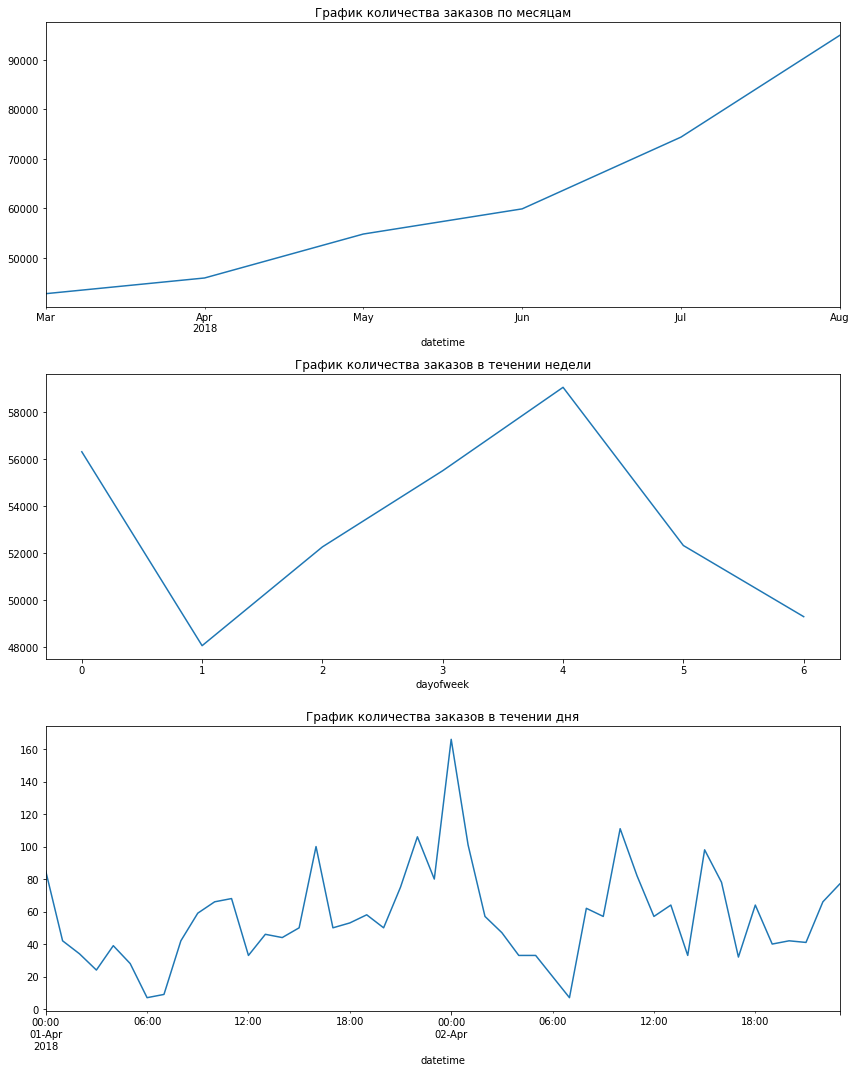

In [11]:
plt.figure(figsize=(12, 15))
plt.subplot(311)
df_month['num_orders'].plot(ax=plt.gca())
plt.title('График количества заказов по месяцам')

plt.subplot(312)
df_copy.groupby('dayofweek')['num_orders'].sum().plot(ax=plt.gca())
plt.title('График количества заказов в течении недели')

plt.subplot(313)
df_copy['num_orders']['2018-04-01':'2018-04-02'].plot(ax=plt.gca())
plt.title('График количества заказов в течении дня')
plt.tight_layout()

По графикам могу заметить, что есть тенденция увеличения заказов с каждым месяцем, большинство заказов в будние дни, особенно в пятницу и в понедельник, в выходные количество заказов падает, а также во вторник мало заказов, а по графику в течении дня, видно, что наименьшее количество заказов приходится на раннее утро.

Посмотрю на скользящее среднее и на стандартное отклонение с окном в 12 часов.

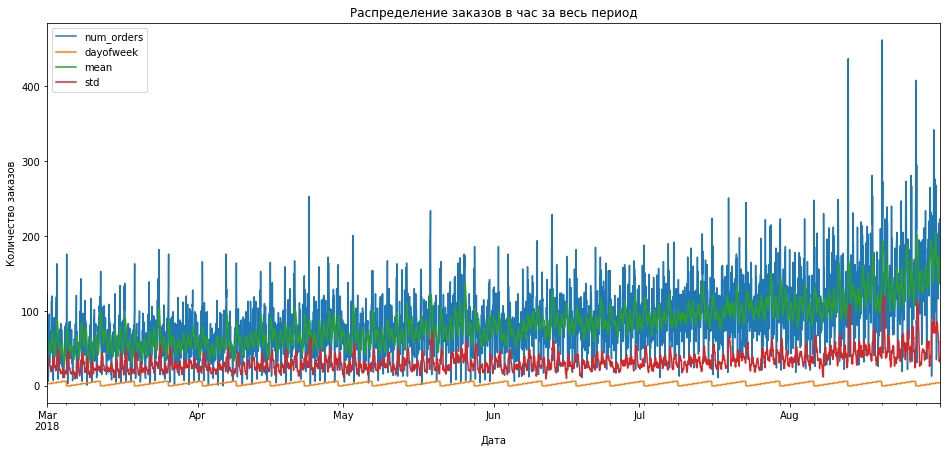

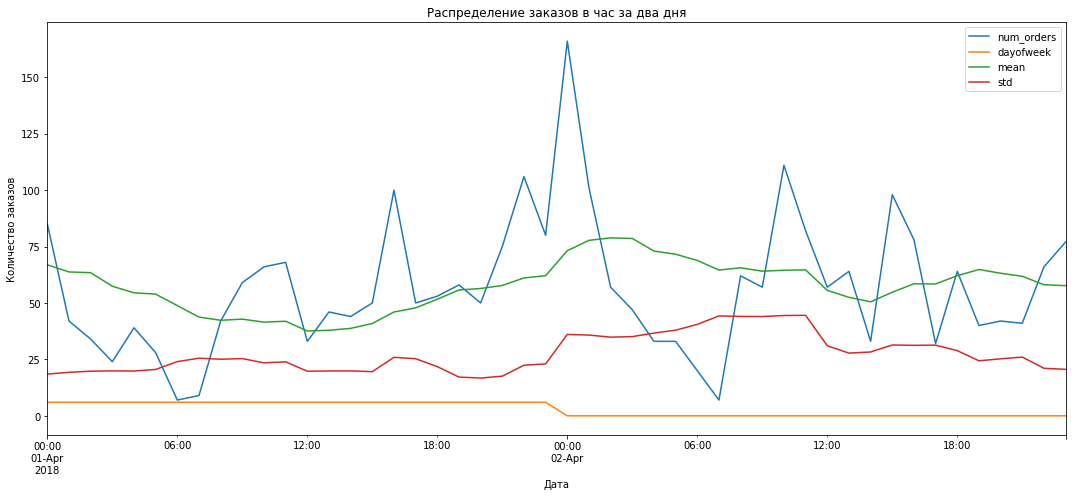

In [12]:
df_copy.plot(figsize=(16, 7))
plt.title('Распределение заказов в час за весь период')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
df_copy['2018-04-01':'2018-04-02'].plot(figsize=(15, 7))
plt.title('Распределение заказов в час за два дня')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()

По первому графику видно, что стандартное отклонение, как и среднее со временем начинают расти. Рассмотрю теперь тренд и сезонность по количеству заказов.

In [13]:
decomposed = seasonal_decompose(df)

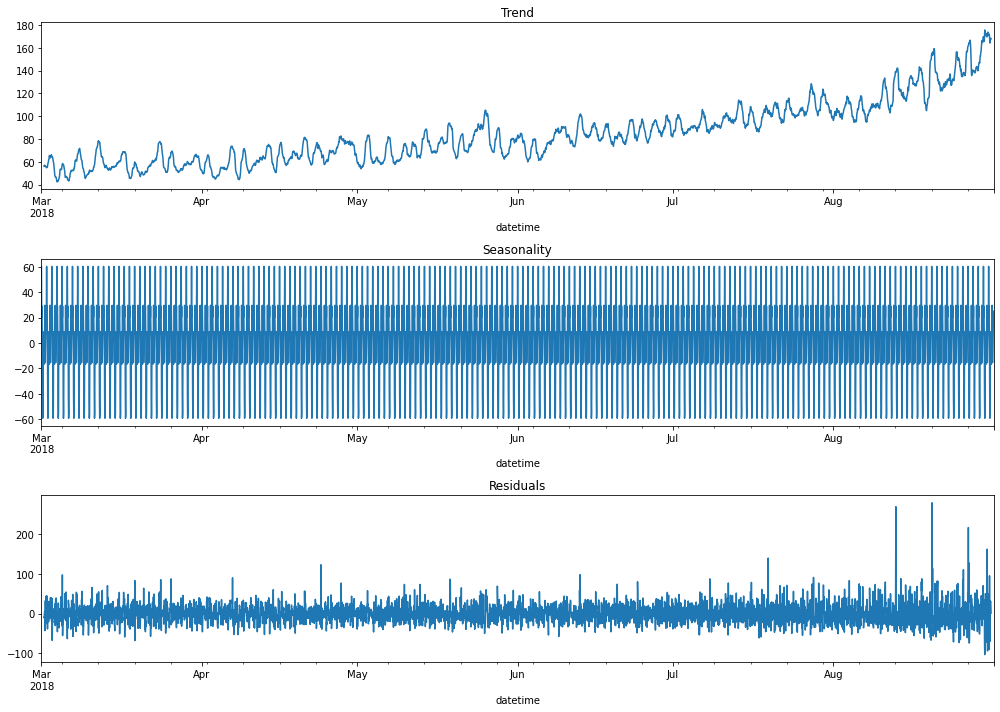

In [14]:
plt.figure(figsize=(14, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Text(0.5, 1.0, 'Сезонность заказов за 7 дней')

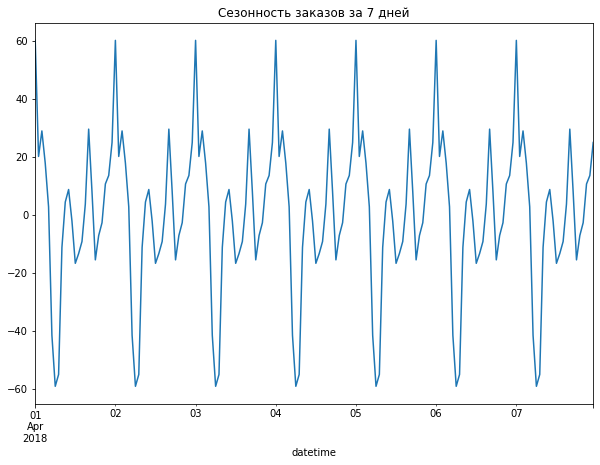

In [15]:
plt.figure(figsize=(10, 7))
decomposed.seasonal['2018-04-01':'2018-04-07'].plot(ax=plt.gca())
plt.title('Сезонность заказов за 7 дней')

На графиках видно, что идет восходящий тренд, возможно это из-за того, что летом люди чаще пользуются такси, по сезонности видны циклично повторяющиеся закономерности во временном ряду, шум летом увеличевается.

**Вывод:**
- Временной ряд стационарен
- Наблюдается восходящий тренд
- По пятницам больше всего заказов
- Ранним утром наименьшее количество заказов

## Обучение

### Подготовка признаков

Напишу функцию для создания признаков.

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    #добавляю календарные признаки
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    data['night'] = (data['hour'].isin([22, 23, 0, 1, 2, 3, 4])).astype('int')
    data['morning'] = (data['hour'].isin([5, 6, 7, 8])).astype('int')
    data['daytime'] = (data['hour'].isin([9, 10, 11, 12, 13, 14, 15, 16, 17])).astype('int')
    data['evening'] = (data['hour'].isin([18, 19, 20, 21])).astype('int')
    data['is_weekend'] = data.dayofweek.isin([5,6]).astype('int')
    
    #добавляю лаги, которые задают максимальный размер отставания общим количеством max_lag
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    
    #добавляю скользящее среднее без текущего значения ряда для рассчета
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data.dropna(inplace=True)

In [17]:
make_features(df, 1, 24)
df.head()

,num_orders,day,hour,dayofweek,night,morning,daytime,evening,is_weekend,lag_1,rolling_mean
datetime,,,,,,,,,,,
2018-03-02 00:00:00,90,2,0,4,1,0,0,0,0,58.0,56.833333
2018-03-02 01:00:00,120,2,1,4,1,0,0,0,0,90.0,55.416667
2018-03-02 02:00:00,75,2,2,4,1,0,0,0,0,120.0,56.875000
2018-03-02 03:00:00,64,2,3,4,1,0,0,0,0,75.0,57.041667
2018-03-02 04:00:00,20,2,4,4,1,0,0,0,0,64.0,56.958333


Разделю таблицу на признаки и целевой признак, а затем на тренировочную и тестовую выборки.

In [18]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']
print(features.shape)
print(target.shape)

(4392, 10)
(4392,)


In [19]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1)

In [20]:
print(features_train.index.min(), features_train.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


Задам параметр кросс-валидации для временного ряда

In [21]:
tscv = TimeSeriesSplit(n_splits=8)

### Обучение моделей

Рассмотрю модели линейной регрессии, дерева решений, случайного леса, LightGBM и CatBoost. Создам списки, в которые будут записываться результаты по каждой модели.

In [22]:
model = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor']

**Линейная регрессия**

In [23]:
%%time
start = time.time()

lr_model = LinearRegression().fit(features_train, target_train)

finish = time.time()
time_cvs_lr = finish - start

lr_rmse = cross_val_score(lr_model,
                            features_train,
                            target_train,
                            cv=tscv,
                            scoring='neg_root_mean_squared_error').mean()

rmse_lr = round(-lr_rmse, 2)

start = time.time()

pred = lr_model.predict(features_train)

finish = time.time()
time_p_lr = finish - start 

print('RMSE for LinearRegression: ', rmse_lr)
print('Time fit: ', time_cvs_lr)
print('Time predict: ', time_p_lr)

RMSE for LinearRegression:  28.3
Time fit:  0.003951549530029297
Time predict:  0.0016665458679199219
CPU times: user 85.2 ms, sys: 64 ms, total: 149 ms
Wall time: 71.8 ms


**Дерево решений**

In [24]:
%%time

dt_model = DecisionTreeRegressor(random_state=42)

#набор параметров, для поиска лучших
# dt_params = {'max_depth': range(5, 33, 4),
#               'max_leaf_nodes': range(0, 100, 10),
#               'min_samples_leaf': range(0, 100, 5)}
dt_params = {'max_depth': [13], 'max_leaf_nodes': [90], 'min_samples_leaf': [25]}

gs_dt = GridSearchCV(dt_model, dt_params,
                      cv=tscv, n_jobs=-1,
                     scoring='neg_root_mean_squared_error')

model_gs_dt = gs_dt.fit(features_train, target_train)

rmse_dt = round(-gs_dt.best_score_, 2)

print('RMSE for DecisionTreeRegressor: ', rmse_dt)
print('Best params: ', gs_dt.best_params_)
print('Time fit: ', gs_dt.cv_results_['mean_fit_time'])
print('Time predict: ', gs_dt.cv_results_['mean_score_time'])

RMSE for DecisionTreeRegressor:  26.09
Best params:  {'max_depth': 13, 'max_leaf_nodes': 90, 'min_samples_leaf': 25}
Time fit:  [0.00674093]
Time predict:  [0.00175992]
CPU times: user 85.2 ms, sys: 4.28 ms, total: 89.5 ms
Wall time: 99.5 ms


**Случайный лес**

In [25]:
%%time

rf_model = RandomForestRegressor(random_state=42)

#набор параметров, для поиска лучших
# rf_params = {'n_estimators': range(10, 41, 5),
#              'max_depth': range(5, 33, 4),
#              'max_leaf_nodes': range(0, 100, 10),
#              'min_samples_leaf': range(0, 100, 5)}

rf_params = {'n_estimators': [40],
              'max_depth': [13],
              'max_leaf_nodes': [90],
              'min_samples_leaf': [5]}

gs_rf = GridSearchCV(rf_model, rf_params,
                     cv=tscv, n_jobs=-1,
                     scoring='neg_root_mean_squared_error')

model_gs_rf = gs_rf.fit(features_train, target_train)

rmse_rf = round(-gs_rf.best_score_, 2)

print('RMSE for RandomForestRegressor: ', rmse_rf)
print('Best params: ', gs_rf.best_params_)
print('Time fit: ', gs_rf.cv_results_['mean_fit_time'])
print('Time predict: ', gs_rf.cv_results_['mean_score_time'])

RMSE for RandomForestRegressor:  25.06
Best params:  {'max_depth': 13, 'max_leaf_nodes': 90, 'min_samples_leaf': 5, 'n_estimators': 40}
Time fit:  [0.1554037]
Time predict:  [0.00615808]
CPU times: user 1.55 s, sys: 8.01 ms, total: 1.56 s
Wall time: 1.56 s


**CatBoostRegressor**

In [26]:
%%time

cbr_model = CatBoostRegressor(random_state=42, loss_function='RMSE', logging_level='Silent')
#набор параметров, для поиска лучших
# cbr_params = {'iterations': [50, 200, 500, 1000],
#              'depth': [2, 5, 9, 15, 22],
#              'learning_rate': [0.1, 0.25]}

cbr_params = {'iterations': [200],
             'depth': [5],
             'learning_rate': [0.1]}

gs_cbr = GridSearchCV(cbr_model, cbr_params,
                     cv=tscv, n_jobs=-1,
                     scoring='neg_root_mean_squared_error')

model_gs_cbr = gs_cbr.fit(features_train, target_train)

rmse_cbr = round(-gs_cbr.best_score_, 2)

print('RMSE for CatBoostRegressor: ', rmse_cbr)
print('Best params: ', gs_cbr.best_params_)
print('Time fit: ', gs_cbr.cv_results_['mean_fit_time'])
print('Time predict: ', gs_cbr.cv_results_['mean_score_time'])

RMSE for CatBoostRegressor:  24.83
Best params:  {'depth': 5, 'iterations': 200, 'learning_rate': 0.1}
Time fit:  [0.73210898]
Time predict:  [0.00196075]
CPU times: user 1.32 s, sys: 222 ms, total: 1.54 s
Wall time: 6.71 s


**LightGBM**

In [27]:
%%time

lgbm_model = LGBMRegressor(random_state=42, objective="RMSE")
#набор параметров, для поиска лучших
# lgbm_params = {'n_estimators': range(50, 600, 50),
#              'max_depth': range(2, 30, 2),
#              'learning_rate': [0.1, 0.25],
#                'num_leaves': [20, 50, 70, 100]}

lgbm_params = {'n_estimators': [50],
             'max_depth': [8],
             'learning_rate': [0.1],
               'num_leaves': [70]}

gs_lgbm = GridSearchCV(lgbm_model, lgbm_params,
                     cv=tscv, n_jobs=-1,
                     scoring='neg_root_mean_squared_error',
                     verbose=False)

model_gs_lgbm = gs_lgbm.fit(features_train, target_train)

rmse_lgbm = round(-gs_lgbm.best_score_, 2)

print('RMSE for LGBMRegressor: ', rmse_lgbm)
print('Best params: ', gs_lgbm.best_params_)
print('Time fit: ', gs_lgbm.cv_results_['mean_fit_time'])
print('Time predict: ', gs_lgbm.cv_results_['mean_score_time'])

RMSE for LGBMRegressor:  24.7
Best params:  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 50, 'num_leaves': 70}
Time fit:  [0.47280961]
Time predict:  [0.02737698]
CPU times: user 4.59 s, sys: 11.5 ms, total: 4.6 s
Wall time: 4.61 s


In [28]:
results = pd.DataFrame({'RMSE_score' : [rmse_lr, rmse_dt, rmse_rf, rmse_cbr, rmse_lgbm],
                        'Time_fit' : [time_cvs_lr, gs_dt.cv_results_['mean_fit_time'],
                                      gs_rf.cv_results_['mean_fit_time'], gs_cbr.cv_results_['mean_fit_time'],
                                      gs_lgbm.cv_results_['mean_fit_time']],
                        'Time_predict' : [time_p_lr, gs_dt.cv_results_['mean_score_time'], 
                                          gs_rf.cv_results_['mean_score_time'], gs_cbr.cv_results_['mean_score_time'], 
                                          gs_lgbm.cv_results_['mean_score_time']]},
                       index=model).sort_values(by='RMSE_score', ascending=True)
results

,RMSE_score,Time_fit,Time_predict
LGBMRegressor,24.70,[0.4728096127510071],[0.02737697958946228]
CatBoostRegressor,24.83,[0.7321089804172516],[0.00196075439453125]
RandomForestRegressor,25.06,[0.15540370345115662],[0.00615808367729187]
DecisionTreeRegressor,26.09,[0.006740927696228027],[0.0017599165439605713]
LinearRegression,28.30,0.003952,0.001667


**Вывод:**

В ходе обучения моделей, были обучены модели с подбором гиперпараметров:
- LinearRegression;
- DecisionTreeRegressor;
- RandomForestRegressor;
- CatBoostRegressor;
- LGBMRegressor.
 Лучшее значение метрики RMSE показала модель LGBMRegressor, а худшее LinearRegression.

## Тестирование

Лучшую метрику качества RMSE показала модель LGBMRegressor, проверю данные тестовой выборки на ней. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [29]:
%%time
final_pred = model_gs_lgbm.predict(features_test)

rmse_test = mean_squared_error(target_test, final_pred, squared=False)

print(f'RMSE на тестовой выборке: {round(rmse_test, 2)}')

RMSE на тестовой выборке: 45.64
CPU times: user 22.3 ms, sys: 0 ns, total: 22.3 ms
Wall time: 68 ms


Значение метрики RMSE на тестовой выборке равна 45.64, что соответствует критерию и ниже 48.
Отображу на графике, как выглядят реальные значения и предсказания. Период возьму в 2 дня.

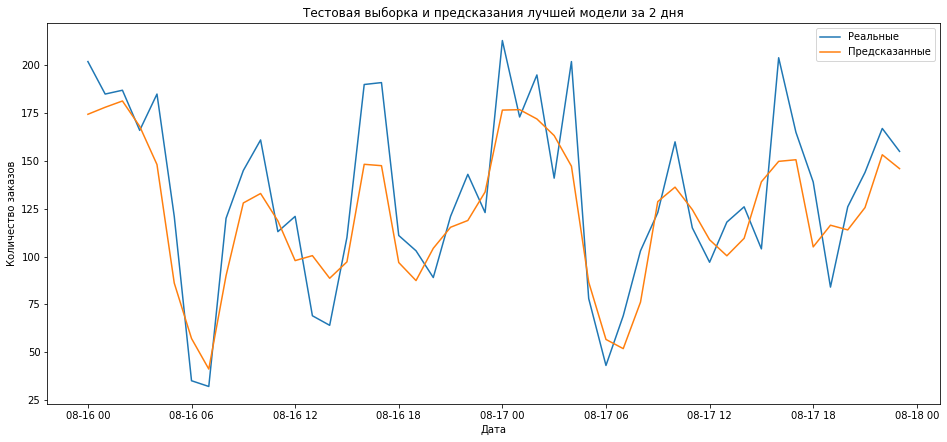

In [30]:
predictions = pd.DataFrame(data = final_pred, columns = ['predictions'], index = target_test.index)
plt.figure(figsize=(16,7))
plt.plot(target_test['2018-08-16':'2018-08-17'])
plt.plot(predictions['2018-08-16':'2018-08-17'])
plt.title('Тестовая выборка и предсказания лучшей модели за 2 дня')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

**Вывод:**

Проведена проверка лучшей модели LGBMRegressor на тестовой выборке, значение метрики RMSE = 42.98. Данное значение соответствует требованиям проекта. 

# Общий вывод

В данном проекте были выполнены следующие задачи:
 - Подгружены исходные данные и проведено ресемплирование по 1 часу.
 - Проведен анализ исходных данных.
 - Обучены модели:
    - LinearRegression;
    - DecisionTreeRegressor;
    - RandomForestRegressor;
    - CatBoostRegressor;
    - LGBMRegressor.
 - Найдено лучшее значение метрики RMSE = 24.43, соответствующее модели LGBMRegressor.
 - Проверены данные лучшей модели на тестовой выборке.
 - Значение метрики RMSE при проверке на тестовой выборке составляет 42.98.
 
Лучшая модель соответствует требованиям проекта. Значение метрики RMSE на тестовой выборке меньше 48. Данную модель можно использовать для прогнозирования количества заказов такси на следующий час.